In [1]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10, 6)

db_con = psycopg2.connect(
    host="localhost",
    port="5432",
    database="hoard_test_retr",
    user="hoarder",
    password="password")

In [2]:
# Get ping rounds
pings = pd.read_sql_query("""select ping_round from fetch_results group by ping_round order by ping_round;""", db_con)
cids = pd.read_sql_query("""SELECT cid_hash FROM cid_info;""", db_con) 

In [3]:
# Get the CID Publish times for the CIDs
pub_times = pd.read_sql_query("""
    select cid_hash, gen_time from cid_info order by cid_hash;
    """, db_con)

# Get total pub time 
mn = min(pub_times['gen_time'])
mx = max(pub_times['gen_time'])

pub_t = (mx - mn) / 60 # conver to mins
print(f'{pub_t} mins to publish the CIDs')

0.38333333333333336 mins to publish the CIDs


In [4]:
# Check whether the content was retrievable from the Network over the study


fetch_dist = []
pr_h_dist = []
k_clos = []
f_prov_dist = []

round_start_time = []
retrievability = []

round_hours = []

for _, row in pings.iterrows():    
    # get the results of the fetch round
    fetch_round = pd.read_sql_query(f"""
        select cid_hash, fetch_time, fetch_duration, holders_ping_duration, find_prov_duration, get_closest_peer_duration, is_retrievable from fetch_results where ping_round={row['ping_round']} order by cid_hash;
        """, db_con)
    
    if len(fetch_round) != len(cids):
        print("dismatch", len(fetch_round), len(cids))
        
    
    # calculate the time from the initial publish of the CIDs
    fetch_round['succeed'] = fetch_round["is_retrievable"].astype(int)
    
    # Get total pub time
    fetch_round['fetch_duration'] /= 60 * 1000
    pub_t = fetch_round['fetch_duration'].to_numpy()
    
    # PR Holders ping
    
    fetch_round['holders_ping_duration'] /= 60 * 1000
    pr_d = fetch_round['holders_ping_duration'].to_numpy()
    
    # Find provider in the network
    
    fetch_round['find_prov_duration'] /= 60 * 1000
    prov_d = fetch_round['find_prov_duration'].to_numpy()
    
    # Calculate the k close peers
    fetch_round['get_closest_peer_duration'] /= 60 * 1000
    k_close_d = fetch_round['get_closest_peer_duration'].to_numpy()
    
    
    fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
    pp = fetch_round['time of pub'].to_numpy()
    
    
    fetch_dist.append(pub_t)
    pr_h_dist.append(pr_d)
    f_prov_dist.append(prov_d)
    k_clos.append(k_close_d)
    round_start_time.append(pp)
    retrievability.append(fetch_round['succeed'].to_numpy())
    round_hours.append(np.mean(pp))



dismatch 18 20
dismatch 17 20
dismatch 19 20
dismatch 19 20
dismatch 18 20
dismatch 13 20
dismatch 19 20
dismatch 18 20


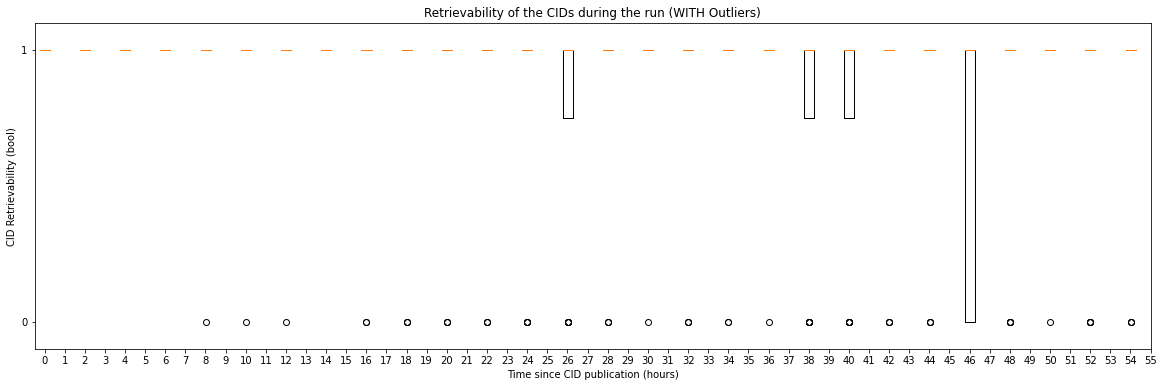

In [5]:
fig, ax = plt.subplots(figsize=(20,6))
ax.boxplot(retrievability, positions=round_hours, showfliers=True)
ax.set_title("Retrievability of the CIDs during the run (WITH Outliers)")
ax.set_ylabel("CID Retrievability (bool)")
ax.set_xlabel("Time since CID publication (hours)")

round_hours = np.around(round_hours, decimals=1)
ax.set_yticks([0, 1])
ax.set_ylim(-0.1, 1.1)
ax.margins(x=0)
ax.set_xticks(np.arange(np.round(round_hours[-1])+2), np.arange(np.round(round_hours[-1])+2).astype(int))

    

Text(0.5, 0, 'ping rounds')

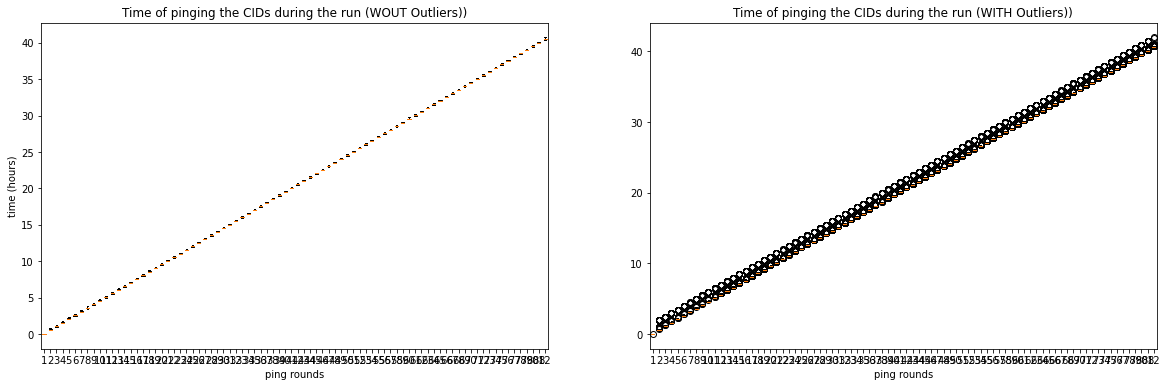

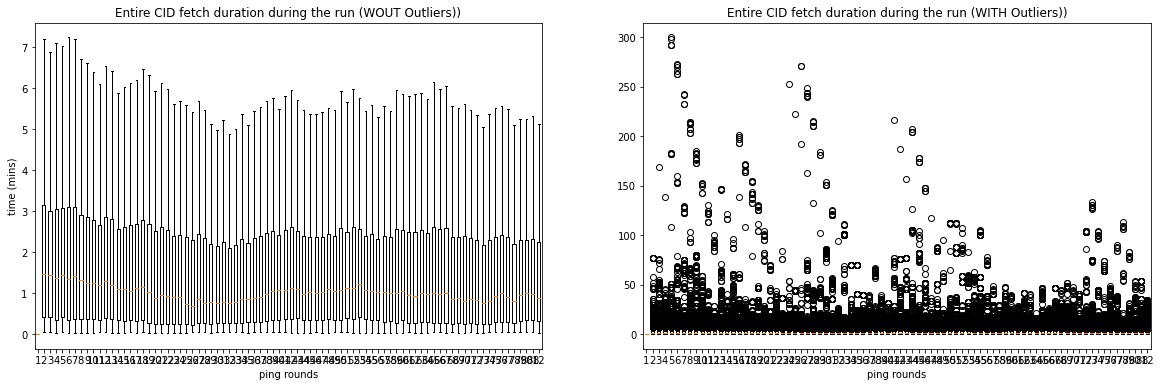

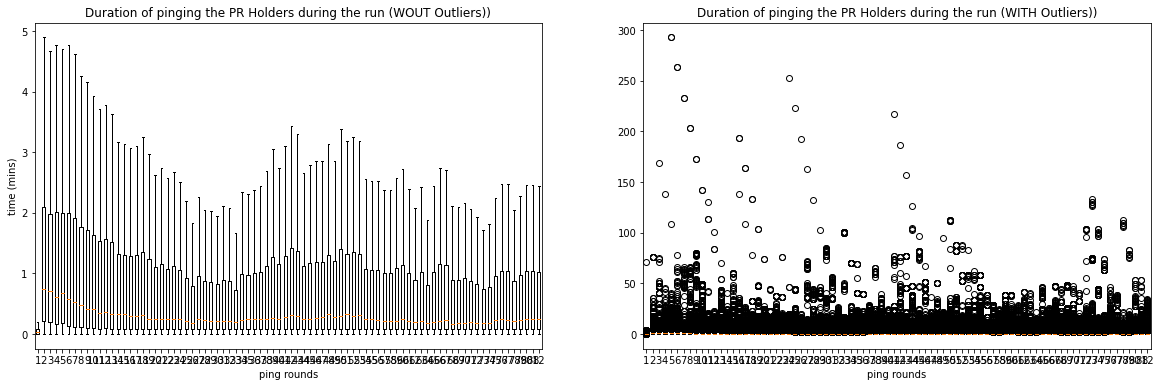

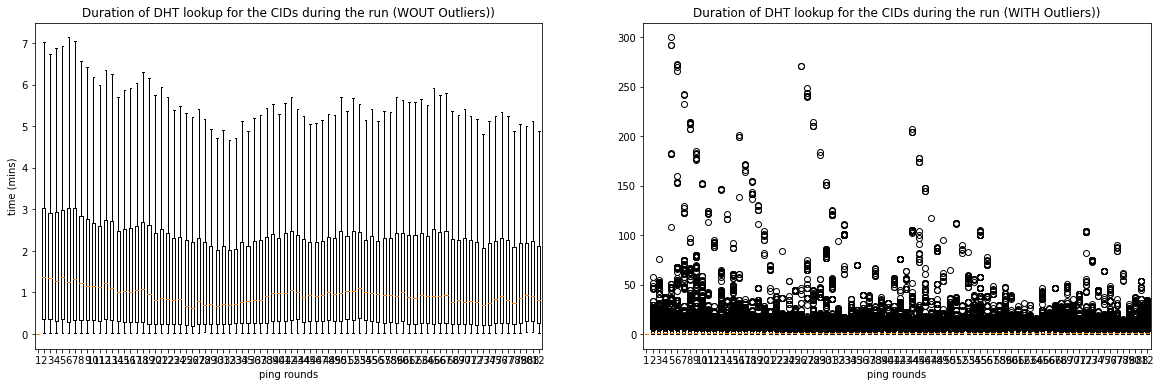

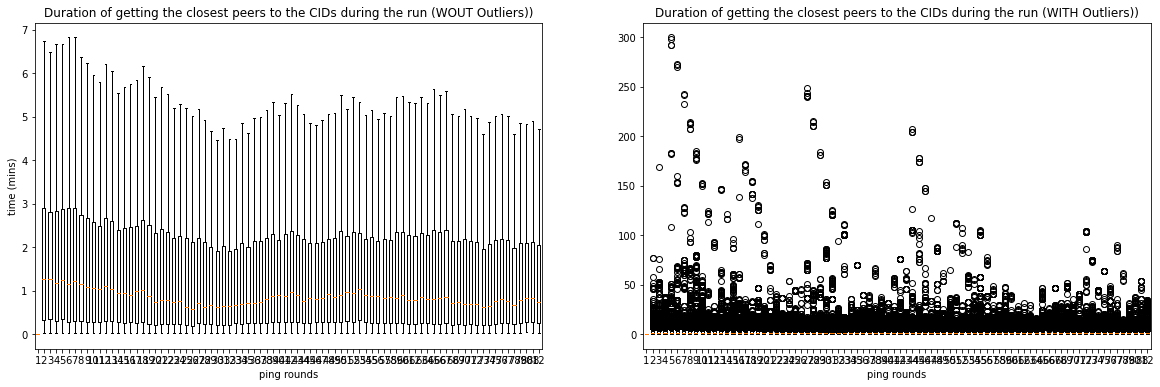

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.boxplot(round_start_time, showfliers=False)
ax1.set_title("Time of pinging the CIDs during the run (WOUT Outliers))")
ax1.set_ylabel("time (hours)")
ax1.set_xlabel("ping rounds")
ax2.boxplot(round_start_time, showfliers=True)
ax2.set_title("Time of pinging the CIDs during the run (WITH Outliers))")
ax2.set_xlabel("ping rounds")

    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.boxplot(fetch_dist, showfliers=False)
ax1.set_title("Entire CID fetch duration during the run (WOUT Outliers))")
ax1.set_ylabel("time (mins)")
ax1.set_xlabel("ping rounds")
ax2.boxplot(fetch_dist, showfliers=True)
ax2.set_title("Entire CID fetch duration during the run (WITH Outliers))")
ax2.set_xlabel("ping rounds")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.boxplot(pr_h_dist, showfliers=False)
ax1.set_title("Duration of pinging the PR Holders during the run (WOUT Outliers))")
ax1.set_ylabel("time (mins)")
ax1.set_xlabel("ping rounds")
ax2.boxplot(pr_h_dist, showfliers=True)
ax2.set_title("Duration of pinging the PR Holders during the run (WITH Outliers))")
ax2.set_xlabel("ping rounds")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.boxplot(f_prov_dist, showfliers=False)
ax1.set_title("Duration of DHT lookup for the CIDs during the run (WOUT Outliers))")
ax1.set_ylabel("time (mins)")
ax1.set_xlabel("ping rounds")
ax2.boxplot(f_prov_dist, showfliers=True)
ax2.set_title("Duration of DHT lookup for the CIDs during the run (WITH Outliers))")
ax2.set_xlabel("ping rounds")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.boxplot(k_clos, showfliers=False)
ax1.set_title("Duration of getting the closest peers to the CIDs during the run (WOUT Outliers))")
ax1.set_ylabel("time (mins)")
ax1.set_xlabel("ping rounds")
ax2.boxplot(k_clos, showfliers=True)
ax2.set_title("Duration of getting the closest peers to the CIDs during the run (WITH Outliers))")
ax2.set_xlabel("ping rounds")


In [ ]:
db_con.close()